<a href="https://colab.research.google.com/github/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial120_applying_trained_unet_model_to_large_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/85gWhlZiZ4E

**Making semantic segmentation predictions on large images by using...**


1.   **Patchify:** Divide images into smaller patches, predict and join the patches back together. 
2.   **Smooth tiled predictions:** Use existing library that preicts each patch with some overlap and then blends the predictions smoothly. https://github.com/Vooban/Smoothly-Blend-Image-Patches



In [ ]:
!pip install patchify

In [ ]:
from patchify import patchify, unpatchify
import cv2
import numpy as np
from matplotlib import pyplot as plt

**Prediction using patchify**

In [ ]:
#Predict on large image
large_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/sandstone/large_images/large_image.tif', 0)
#This will split the image into small images of shape [3,3]
patches = patchify(large_image, (128, 128), step=128)  #Step=256 for 256 patches means no overlap
print("Large image shape is: ", large_image.shape)
print("Patches array shape is: ", patches.shape)

Large image shape is:  (768, 768)
Patches array shape is:  (6, 6, 128, 128)


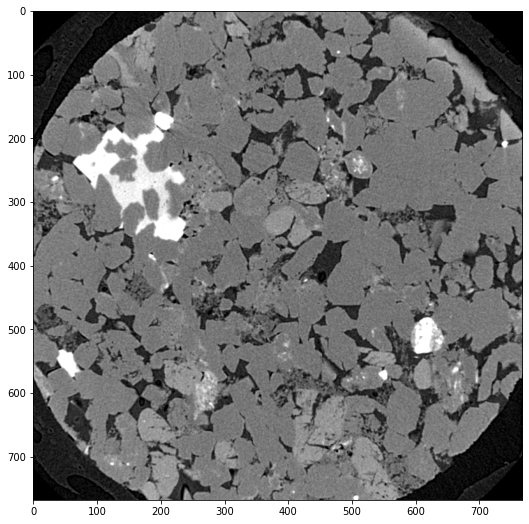

In [ ]:
plt.figure(figsize=(9, 9))
plt.imshow(large_image, cmap='gray')

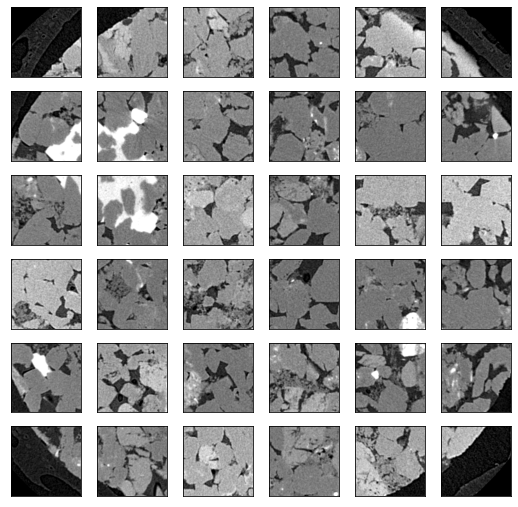

In [ ]:
plt.figure(figsize=(9, 9))
square = 6
ix = 1
for i in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(patches[i, j, :, :], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5", compile=False)

In [ ]:
#Apply a trained model on large image, patch by patch
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print("Now predicting on patch", i,j)
        
        single_patch = patches[i,j,:,:]  
        single_patch = single_patch / 255.  

        single_patch = np.expand_dims(np.array(single_patch), axis=2)
        single_patch_input=np.expand_dims(single_patch, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )

Now predicting on patch 0 0
Now predicting on patch 0 1
Now predicting on patch 0 2
Now predicting on patch 0 3
Now predicting on patch 0 4
Now predicting on patch 0 5
Now predicting on patch 1 0
Now predicting on patch 1 1
Now predicting on patch 1 2
Now predicting on patch 1 3
Now predicting on patch 1 4
Now predicting on patch 1 5
Now predicting on patch 2 0
Now predicting on patch 2 1
Now predicting on patch 2 2
Now predicting on patch 2 3
Now predicting on patch 2 4
Now predicting on patch 2 5
Now predicting on patch 3 0
Now predicting on patch 3 1
Now predicting on patch 3 2
Now predicting on patch 3 3
Now predicting on patch 3 4
Now predicting on patch 3 5
Now predicting on patch 4 0
Now predicting on patch 4 1
Now predicting on patch 4 2
Now predicting on patch 4 3
Now predicting on patch 4 4
Now predicting on patch 4 5
Now predicting on patch 5 0
Now predicting on patch 5 1
Now predicting on patch 5 2
Now predicting on patch 5 3
Now predicting on patch 5 4
Now predicting on pa

In [ ]:
predicted_patches_reshaped.shape

(6, 6, 128, 128)

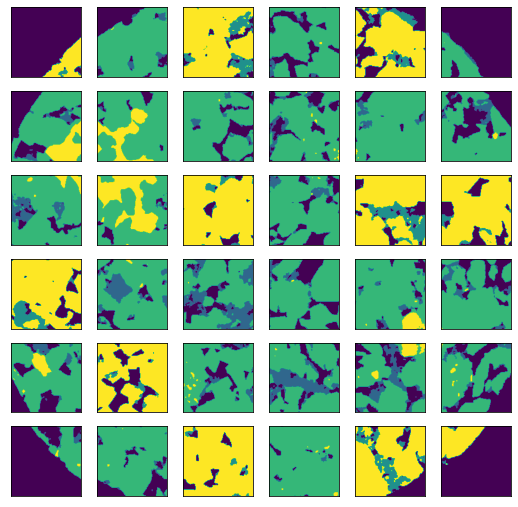

In [ ]:
plt.figure(figsize=(9, 9))
square = 6
ix = 1
for i in range(square):
	for j in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot 
		plt.imshow(predicted_patches_reshaped[i, j, :, :])
		ix += 1
# show the figure
plt.show()

In [ ]:
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
#plt.imsave('your_path_goes_here/segm.jpg', reconstructed_image, cmap='gray')

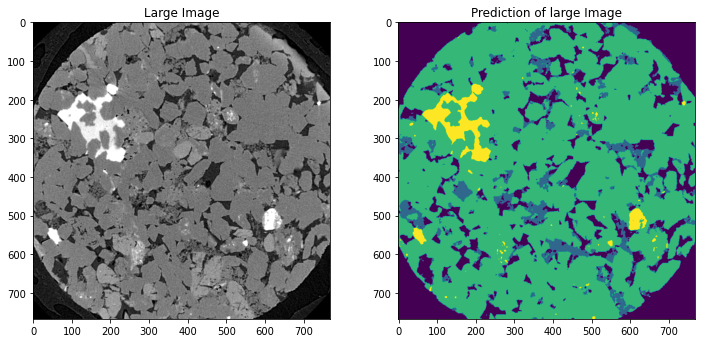

In [ ]:

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image)
plt.show()


**Using Smooth tiled predictions as described here:**
https://github.com/Vooban/Smoothly-Blend-Image-Patches

In [ ]:
#First connect to your Google drive (i.e. mount the drive)
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/')

In [ ]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [ ]:
#Predict on large image
large_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/sandstone/large_images/large_image.tif', 0)
large_image_scaled = large_image /255.
large_image_scaled = np.expand_dims(large_image_scaled, axis=2)

In [ ]:
print(large_image_scaled.shape)

(768, 768, 1)


In [ ]:
patch_size=128
n_classes=4

In [ ]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial119_sandstone_50epochs.hdf5", compile=False)

In [ ]:
# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    large_image_scaled,    #Must be of shape (x, y, c) --> NOT of the shape (n, x, y, c)
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

100%|██████████| 8/8 [00:20<00:00,  2.56s/it]


In [ ]:
print(predictions_smooth.shape)

(768, 768, 4)


In [ ]:
final_prediction = np.argmax(predictions_smooth, axis=2)

In [ ]:
#Save prediction and original mask for comparison
#plt.imsave('data/test_images/N-34-66-C-c-4-3.tif_segmented.jpg', final_prediction)
#plt.imsave('data/test_images/N-34-66-C-c-4-3.tif_mask.jpg', original_mask)

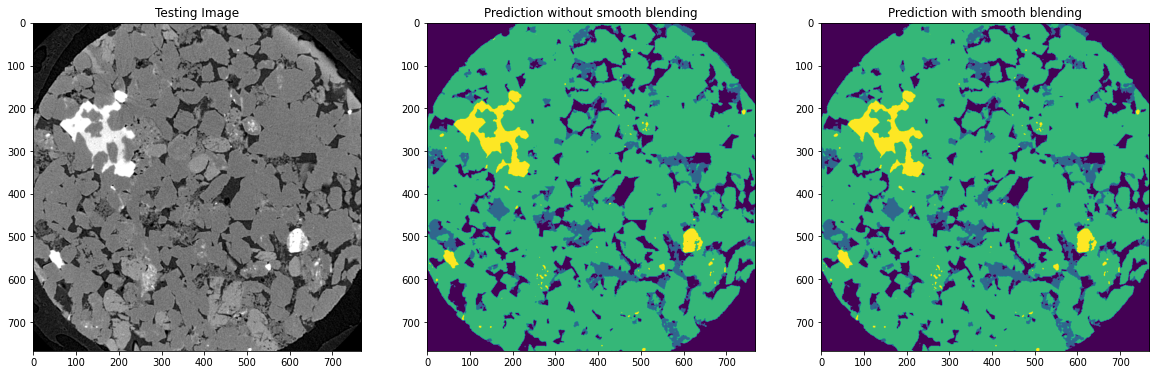

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(132)
plt.title('Prediction without smooth blending')
plt.imshow(reconstructed_image)
plt.subplot(133)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()

